In [107]:
import netwulf as nw
import networkx as nx
import urllib.request
import json
import pandas as pd
import re
import pickle
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests
from nltk.corpus import PlaintextCorpusReader
import urllib.parse
from nltk import word_tokenize
import nltk, re, pprint
import matplotlib_inline
%matplotlib inline
import pickle
from wordcloud import WordCloud
from collections import Counter
import community.community_louvain as community
import math
import powerlaw
import collections
import scipy
import squarify
import seaborn as sb
from nltk.corpus import stopwords
import matplotlib.patches as mpatches
import shutil
nltk.download("stopwords")
lemmatizer = nltk.stem.WordNetLemmatizer()
from collections import defaultdict
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/clairmutebi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [108]:
with open('LargeData/data2022.pkl', 'rb') as f:
    data = pickle.load(f)

# rename columns
data = data.rename(columns={'out_going':'author','in_going':'adressee'})
print(data.columns)

Index(['author', 'adressee', 'id', 'flair', 'comment'], dtype='object')


### Make Graph smaller

In [109]:
# Load graph from a pickle file
with open("LargeData/Directed2022.pkl", "rb") as file:
    G = pickle.load(file)

# Make GCC
UnG = G.to_undirected()
G = nx.subgraph(G, [node for node in G.nodes()][:1000])
G = nx.subgraph(G,max(nx.weakly_connected_components(G), key=len)) # GCC

# Basic statistics

In [20]:
print('Number of nodes: ',G.number_of_nodes())
print('Number of edges: ',G.number_of_edges())

Number of nodes:  924
Number of edges:  22651


In [21]:
print('Number of multiedges: ',len([x for x in G.edges() if G.number_of_edges(x[0],x[1]) > 1]))

Number of multiedges:  14158


Text(0, 0.5, 'Counts')

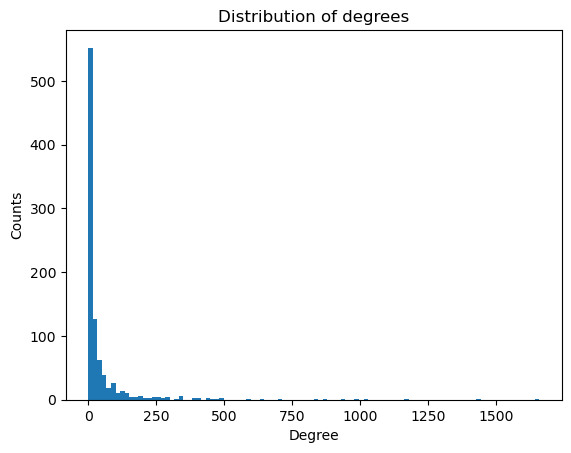

In [22]:
degree_sequence = [d for n, d in G.degree()]
plt.figure()
plt.hist(degree_sequence,bins=100)
plt.title('Distribution of degrees')
plt.xlabel('Degree')
plt.ylabel('Counts')

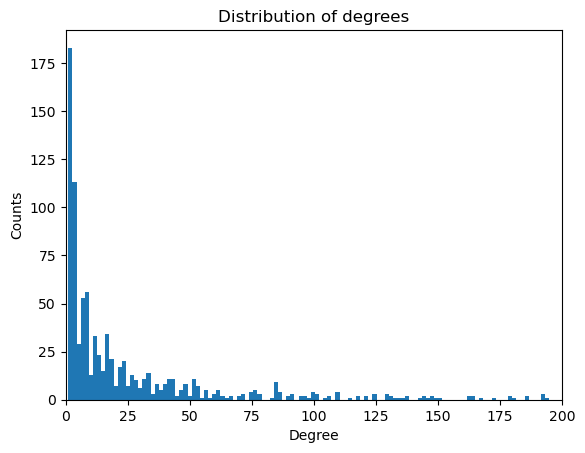

In [23]:
# Plot degree distribution with less tahn 1000 degrees
plt.figure()
plt.hist(degree_sequence,bins=1000)
plt.title('Distribution of degrees')
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.xlim(0,200)
plt.show()

In [24]:
# Find node with highest degree
max_degree = 0
max_degree_node = None
for node in G.nodes():
    if G.degree(node) > max_degree:
        max_degree = G.degree(node)
        max_degree_node = node

print('Node with highest degree: ',max_degree_node,' with degree: ',max_degree)

Node with highest degree:  mirrorconspiracies  with degree:  1658


In [25]:
# Print flair of node with highest degree
print('Flair of node with highest degree: ',G.nodes[max_degree_node]['flair'])

Flair of node with highest degree:  entp


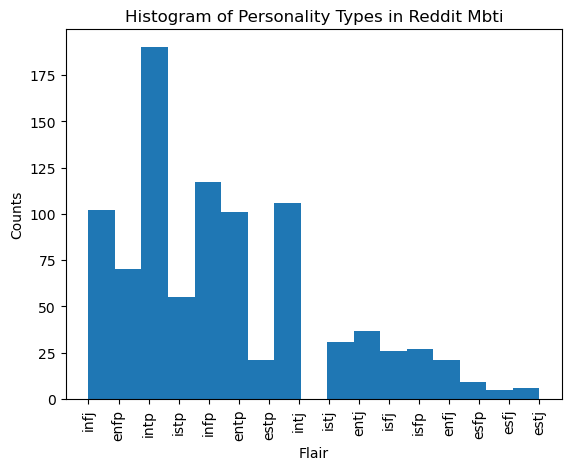

In [26]:
# Distribution of flair
flairs = [G.nodes[node]['flair'] for node in G.nodes()]
plt.figure()
plt.hist(flairs,bins=17)
plt.title('Histogram of Personality Types in Reddit Mbti')
plt.xlabel('Flair')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.show()

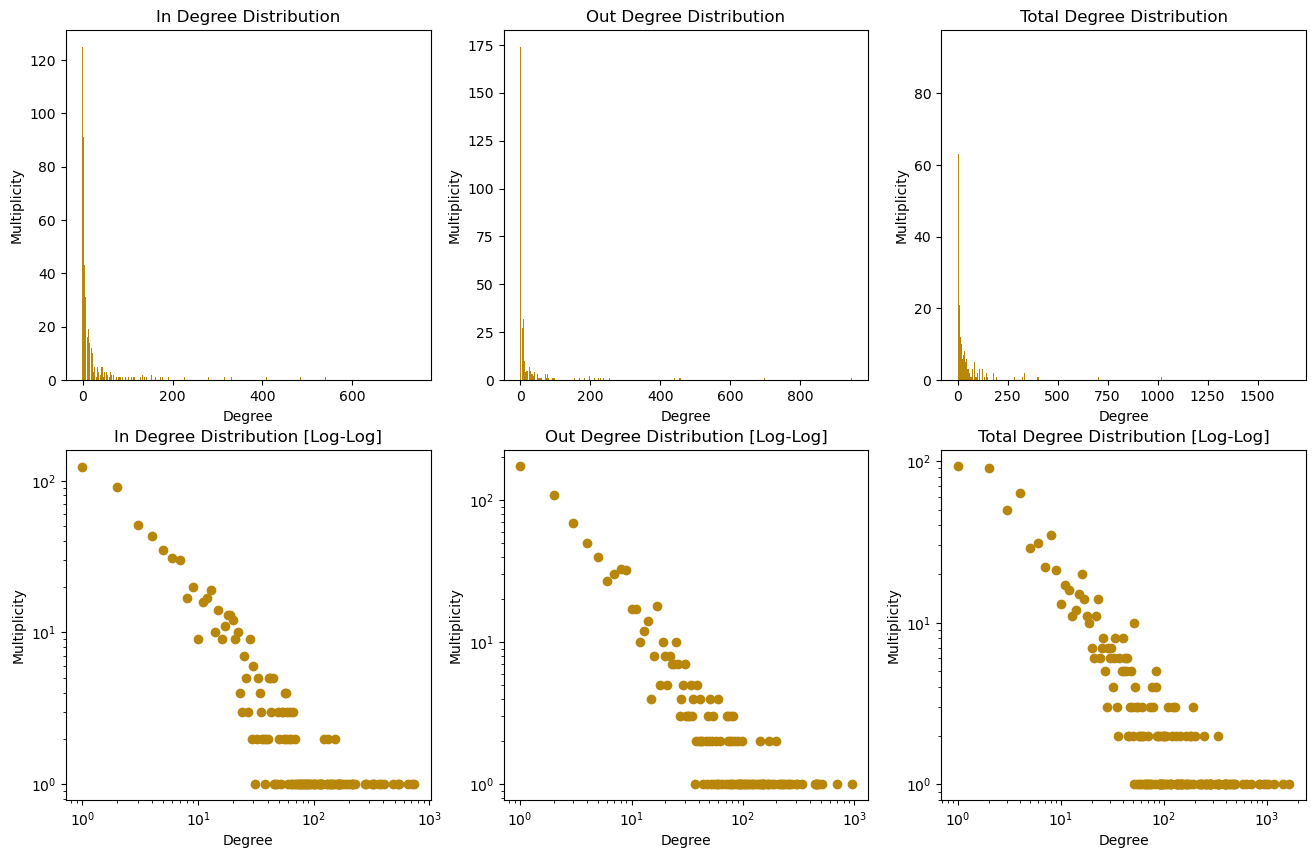

In [27]:
#Plot degree distribution of the Rapper graph
fig,ax = plt.subplots(2,3,figsize=(16,10))

in_degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)  # degree sequence
in_degreeCount = collections.Counter(in_degree_sequence)

ax[0,0].bar(in_degreeCount.keys(), in_degreeCount.values(), color='darkgoldenrod')
ax[0,0].set_title("In Degree Distribution")
ax[0,0].set_ylabel("Multiplicity")
ax[0,0].set_xlabel("Degree")
ax[1,0].loglog(in_degreeCount.keys(), in_degreeCount.values(), color='darkgoldenrod',marker="o",linestyle="None")
ax[1,0].set_title("In Degree Distribution [Log-Log]")
ax[1,0].set_ylabel("Multiplicity")
ax[1,0].set_xlabel("Degree")

out_degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)  # degree sequence
out_degreeCount = collections.Counter(out_degree_sequence)

ax[0,1].bar(out_degreeCount.keys(), out_degreeCount.values(), color='darkgoldenrod')
ax[0,1].set_title("Out Degree Distribution")
ax[0,1].set_ylabel("Multiplicity")
ax[0,1].set_xlabel("Degree")
ax[1,1].loglog(out_degreeCount.keys(), out_degreeCount.values(), color='darkgoldenrod',marker="o",linestyle="None")
ax[1,1].set_title("Out Degree Distribution [Log-Log]")
ax[1,1].set_ylabel("Multiplicity")
ax[1,1].set_xlabel("Degree")

degree_distribution = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount=collections.Counter(degree_distribution)

ax[0,2].bar(degreeCount.keys(), degreeCount.values(), color='darkgoldenrod')
ax[0,2].set_title("Total Degree Distribution")
ax[0,2].set_ylabel("Multiplicity")
ax[0,2].set_xlabel("Degree")
ax[1,2].loglog(degreeCount.keys(), degreeCount.values(), color='darkgoldenrod',marker="o",linestyle="None")
ax[1,2].set_title("Total Degree Distribution [Log-Log]")
ax[1,2].set_ylabel("Multiplicity")
ax[1,2].set_xlabel("Degree")

plt.show()

In [28]:
in_degree_sequence = np.array(in_degree_sequence)
in_degree_sequence = in_degree_sequence[in_degree_sequence!=0]
results=powerlaw.Fit(in_degree_sequence)
print(f"The exponent for in-degree is: {results.power_law.alpha}")

The exponent for in-degree is: 2.2263484548362484


Calculating best minimal value for power law fit
/Users/luxonice/opt/anaconda3/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


In [29]:
out_degree_sequence = np.array(out_degree_sequence)
out_degree_sequence = out_degree_sequence[out_degree_sequence!=0]
out_degree_sequence = out_degree_sequence[out_degree_sequence!=np.nan]

results=powerlaw.Fit(out_degree_sequence)
print(f"The exponent for out-degree is: {results.power_law.alpha}")

The exponent for out-degree is: 1.942606145403052


Calculating best minimal value for power law fit


In [30]:
#Compare to random graph
N=len(G.nodes)
p=2*len(G.edges)/(N*(N-1))

random_graph=nx.erdos_renyi_graph(N,p,directed=False,seed=42)
degree_sequence = sorted([d for n, d in random_graph.degree()], reverse=True)  # degree sequence
degree_sequence = np.array(degree_sequence)
degree_sequence = degree_sequence[degree_sequence!=0]
degreeCount = collections.Counter(in_degree_sequence)
results=powerlaw.Fit(degree_sequence)
print(f"The exponent for a ranom graph is {results.power_law.alpha}")

The exponent for a ranom graph is 23.647045524987636


Calculating best minimal value for power law fit


In [31]:
#nw.visualize(G)

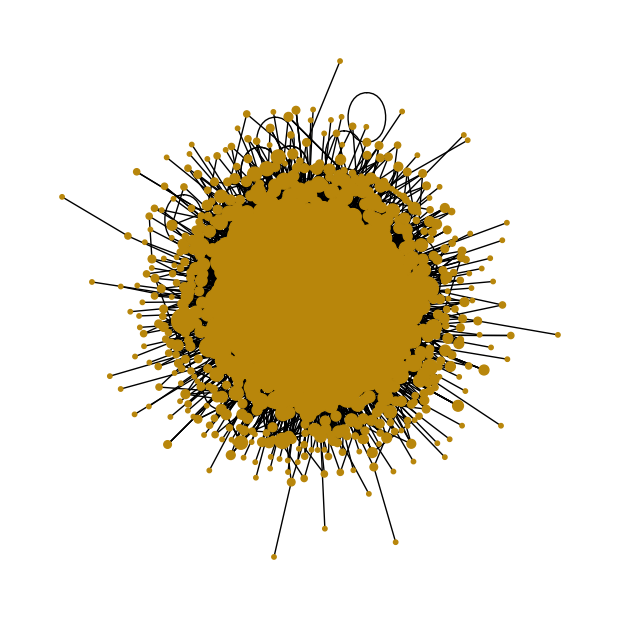

In [32]:
# Convert to undirected graph
UG = G.to_undirected()

# Define node size by degree
node_sizes = []
for node in UG.nodes():
    node_sizes.append(UG.degree[node]*10)

# Draw graph
plt.figure(figsize=(6,6))
nx.draw_kamada_kawai(UG,node_color='darkgoldenrod',node_size=node_sizes, with_labels=False)
plt.show()

# WordCloud

Divide comments after authors flair and save in a file

In [33]:
if not os.path.exists('Flairs'):
    os.makedirs('Flairs')
else:
    shutil.rmtree('Flairs')
    os.makedirs('Flairs')

# Create a txt file with all comments for each flair
for user in G.nodes():
    flair = G.nodes[user]['flair']
    
    # Create txt file for each flair
    if not os.path.exists('Flairs/' + flair + '.txt'):
        # create txt file
        f = open('Flairs/' + flair + '.txt', 'w')
        f.close()
    
    f = open('Flairs/' + flair + '.txt', 'a')
    f.write(G.nodes[user]['comments'] + '\n')
    f.close()


Define preprocessing of text and TermFrequency

In [34]:
# Remove the punctuation, set all lowercase, lemmatize and remove stopwords
def preprocess(text):
    text = re.sub(r'\'s','',text)
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower()
    text = word_tokenize(text)
    text = [t for t in text if t not in nltk.corpus.stopwords.words('english')]
    text = [nltk.WordNetLemmatizer().lemmatize(t) for t in text]
    return text

def TermFrequency(text):
    # Count the occurences of each word
    frequency = nltk.FreqDist(text)
    # Create list of words and occurences
    worddict = dict()
    for key,value in frequency.items():
        worddict[key] = value
    return worddict

Preprocess text - takes approx 1h for full 2022 graph

In [35]:
tmp = []
flair_list = []
for flair in os.listdir('Flairs'):
    tmp.append(preprocess(open('Flairs/' + flair).read()))
    flair_list.append(flair[:-4])

If final version save graph as this takes the longest

In [36]:
# save tmp pickle
with open('LargeData/tmp.pickle', 'wb') as f:
    pickle.dump(tmp, f)

define function to combine all texts

In [37]:
def combine_lists(list_of_lists):
    combined_list = []
    for l in range(len(list_of_lists)):
        combined_list.extend(list_of_lists[l])
    return combined_list

combine all texts

In [38]:
all = combine_lists(tmp)

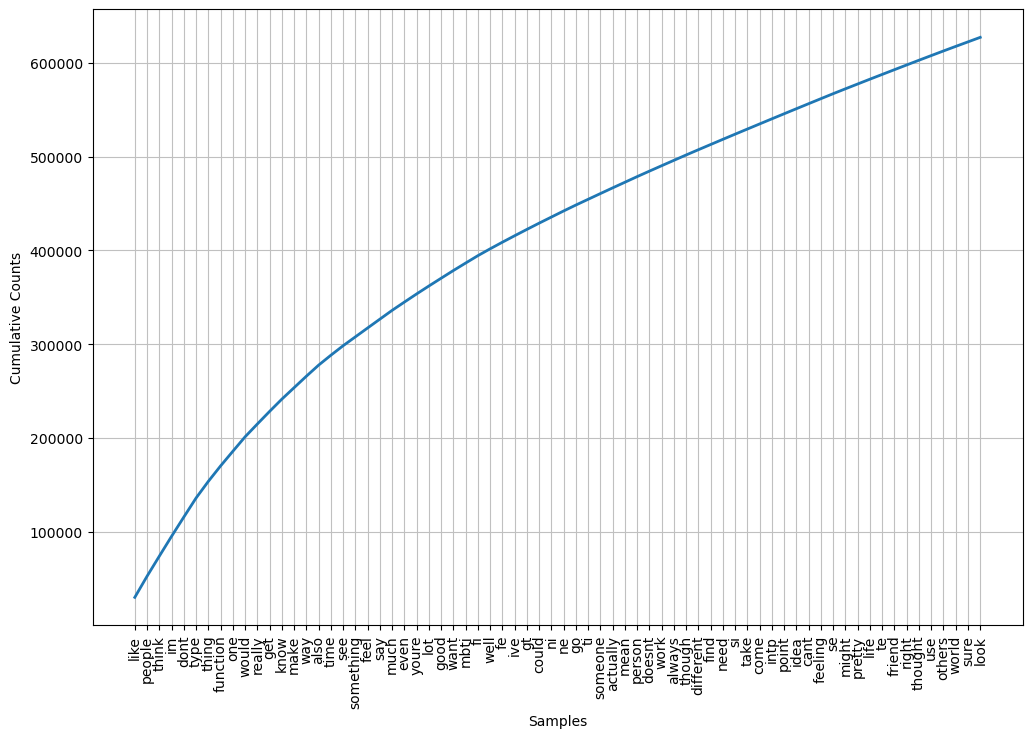

<Axes: xlabel='Samples', ylabel='Cumulative Counts'>

In [39]:
figure = plt.figure(figsize=(12,8))
nltk.FreqDist(all).plot(70, cumulative=True)

define function to remove items from the list

In [40]:
def remove_list(list_,all_lists):
    for l in list_:
        all_lists.remove(l)
    return all_lists

Compute TFTR - takes at least 130min for 1000 nodes. Do it some smarter way.

In [41]:
data_for_wordcloud = []
c = 20
for i in range(len(tmp)):
    print(i)
    TFTR = []
    dict1 = TermFrequency(tmp[i])
    copy_all = all.copy()
    dict2 = TermFrequency(remove_list(tmp[i],copy_all))
    for key in dict1:
        word = key
        freq1 = dict1[key]
        if word in dict2:
            freq2 = dict2[word]
            TFTR.append([key,freq1**2/(freq2+c)])
    data_for_wordcloud.append(TFTR)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [42]:
# save data_for_wordcloud as pkl
with open('LargeData/data_for_wordcloud.pickle', 'wb') as f:
    pickle.dump(data_for_wordcloud, f)

In [43]:
# open data_for_wordcloud as pkl
with open('LargeData/data_for_wordcloud.pickle', 'rb') as f:
    data_for_wordcloud = pickle.load(f)

In [44]:
def TFTR_to_string(TFTR):
    TFTR_string = ''
    for token in TFTR:
        TFTR_string += (token[0] + ' ') * int(token[1])
    return TFTR_string

for i in range(len(data_for_wordcloud)):
    data_for_wordcloud[i] = TFTR_to_string(data_for_wordcloud[i])

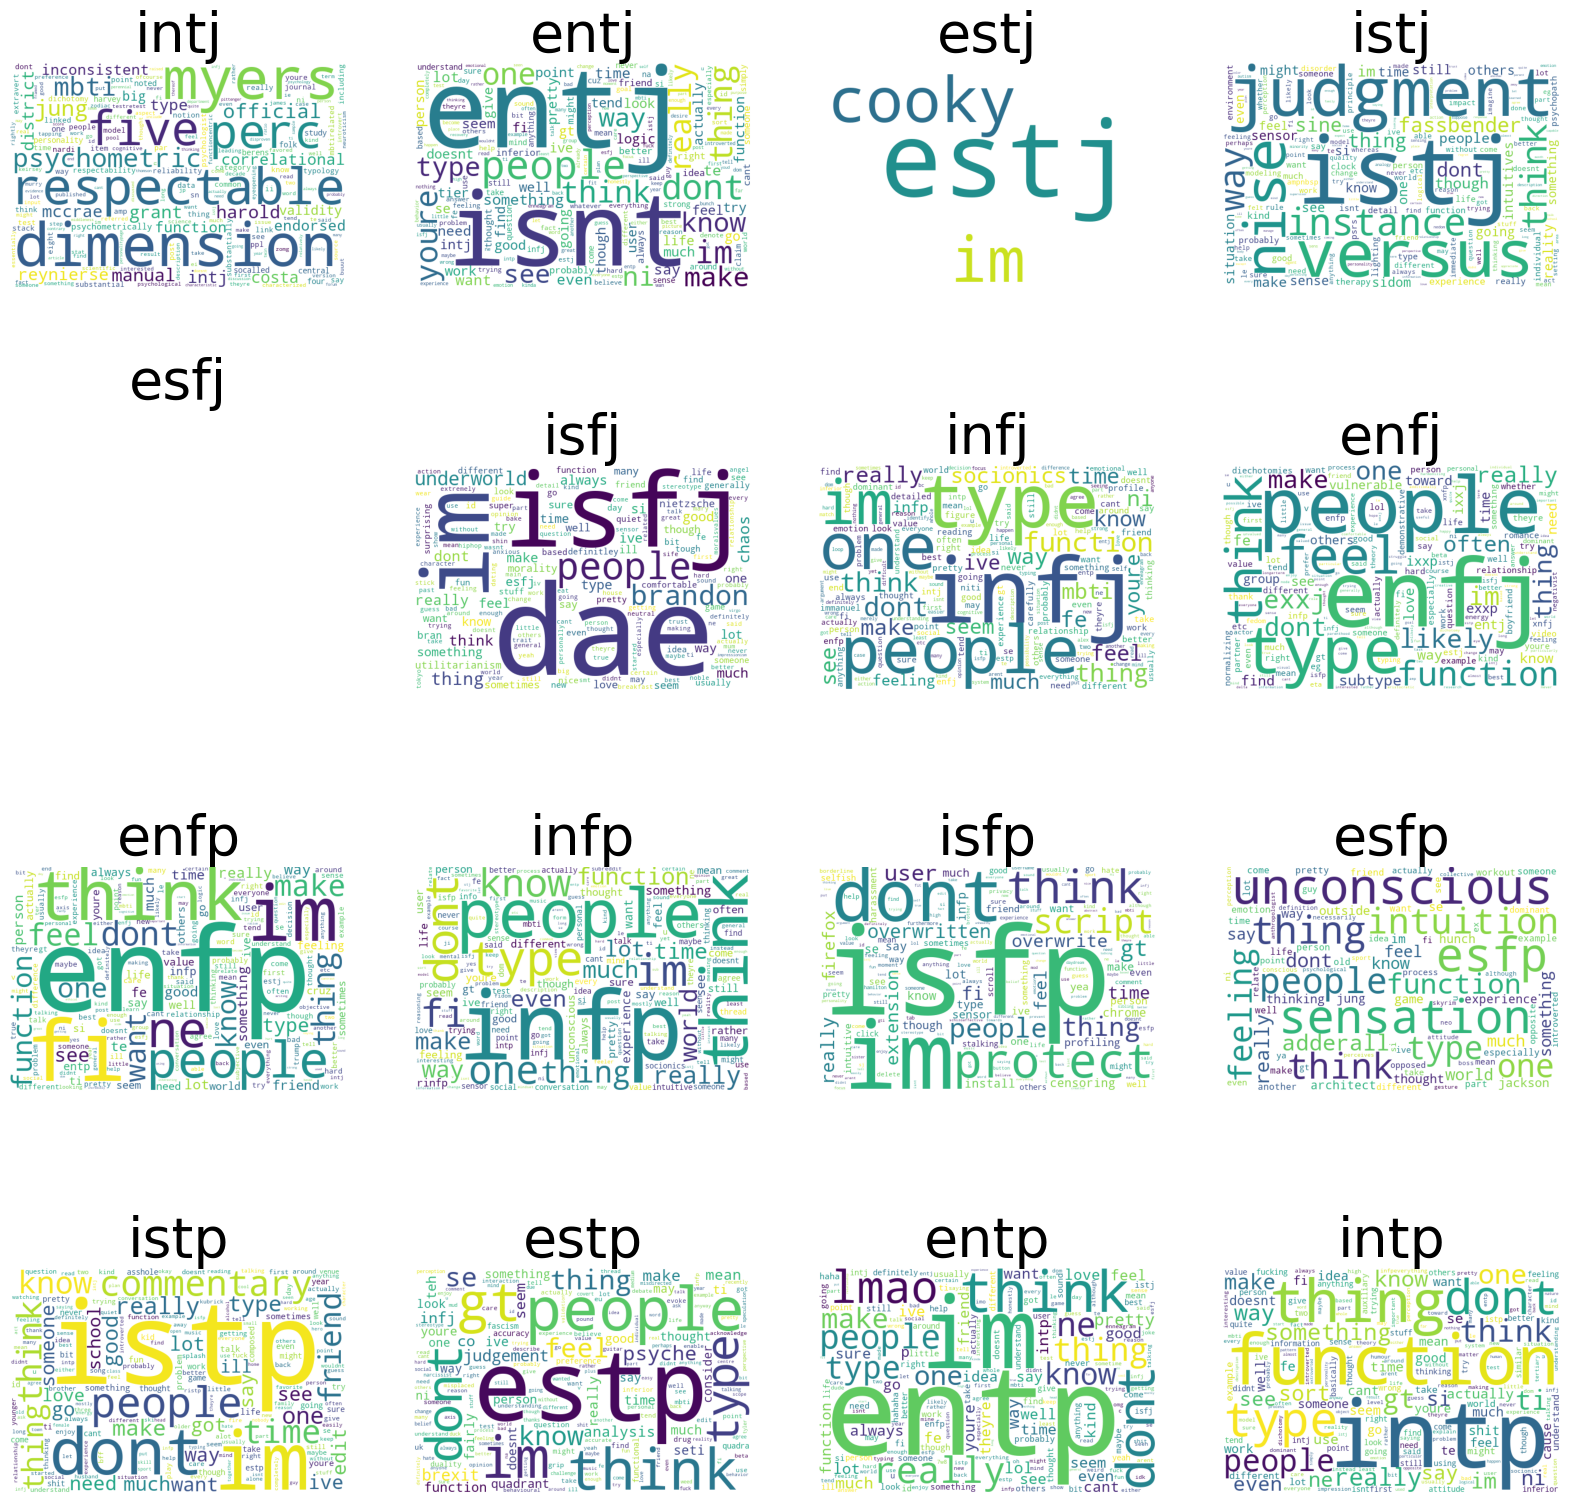

In [45]:
fig, ax = plt.subplots(4, 4, figsize=[20, 20])
for i in range(4):
    for j in range(4):
        if data_for_wordcloud[4*i+j] != '':
            wordcloud = WordCloud(background_color='white', width=600, height=400,collocations=False).generate(data_for_wordcloud[4*i+j])
            ax[i,j].imshow(wordcloud)
        ax[i,j].axis('off')
        ax[i,j].set_title(flair_list[4*i+j],fontsize=40)
plt.show()

# Communities

Finding median and mean number of communities for Graph G

In [110]:
G = G.to_undirected()

# Get node attributes for authors and their flair
authors = list(G.nodes())
flairs = nx.get_node_attributes(G, 'flair')

# Dataframe with authors and flairs
df_flairs = pd.DataFrame(list(flairs.items()), columns=['Author', 'Flair'])

trials = 100
number_of_communities = np.zeros(trials)
for i in range(trials):
    if i % 100 == 0:
        print(i)
    partition = community.best_partition(G)
    number_of_communities[i] = len(set(partition.values()))

med = int(np.median(number_of_communities))
# Print the number of communities
print("Mean number of communities:", np.mean(number_of_communities))
print("Median number of communities:", int(np.median(number_of_communities)))

0
Mean number of communities: 7.04
Median number of communities: 7


Define modularity and partition Graph into communities according to median found above

In [112]:
def modularity(G,partition):
    modularity_vals = []
    L = G.number_of_edges()
    for i in range(len(partition)):
        Lc = G.subgraph(partition[i]).number_of_edges()
        kc = 0
        for node in partition[i]:
            kc += G.degree(node)
        modularity_vals.append(Lc/L - (kc/(2*L))**2)
    return sum(modularity_vals)

while True:
    partition = community.best_partition(G)
    if len(set(partition.values())) == med:
        break


In [113]:
# Create dataframe with author and community
df_community = pd.DataFrame(list(partition.items()),columns = ['Author','Community'])

df_community = df_community.sort_values(by='Community')

# Merge the community information with flair information based on authors
merged_df = pd.merge(df_community, df_flairs, on='Author')


Save file

In [114]:
# Save df_community as pkl
with open('LargeData/df_community.pickle', 'wb') as f:
    pickle.dump(df_community, f)

Compute modularity for best partition

In [115]:
# modularity
print('Modularity of best partition:',modularity(G, [df_community[df_community['Community']==i]['Author'].values for i in range(len(df_community['Community'].unique()))]))

Modularity of best partition: 0.19273461193415575


In [116]:
# Calculate overall flair distribution across all communities
flair_counts = merged_df.groupby('Flair')['Author'].nunique()


In [118]:
specific_community = 1
community_data = merged_df[merged_df['Community'] == specific_community]
community_flair_counts = community_data['Flair'].value_counts()

print("Top flair in community 1: ")
print(community_flair_counts[:3])


Top flair in community 1: 
Flair
intp    15
infp    10
intj     9
Name: count, dtype: int64


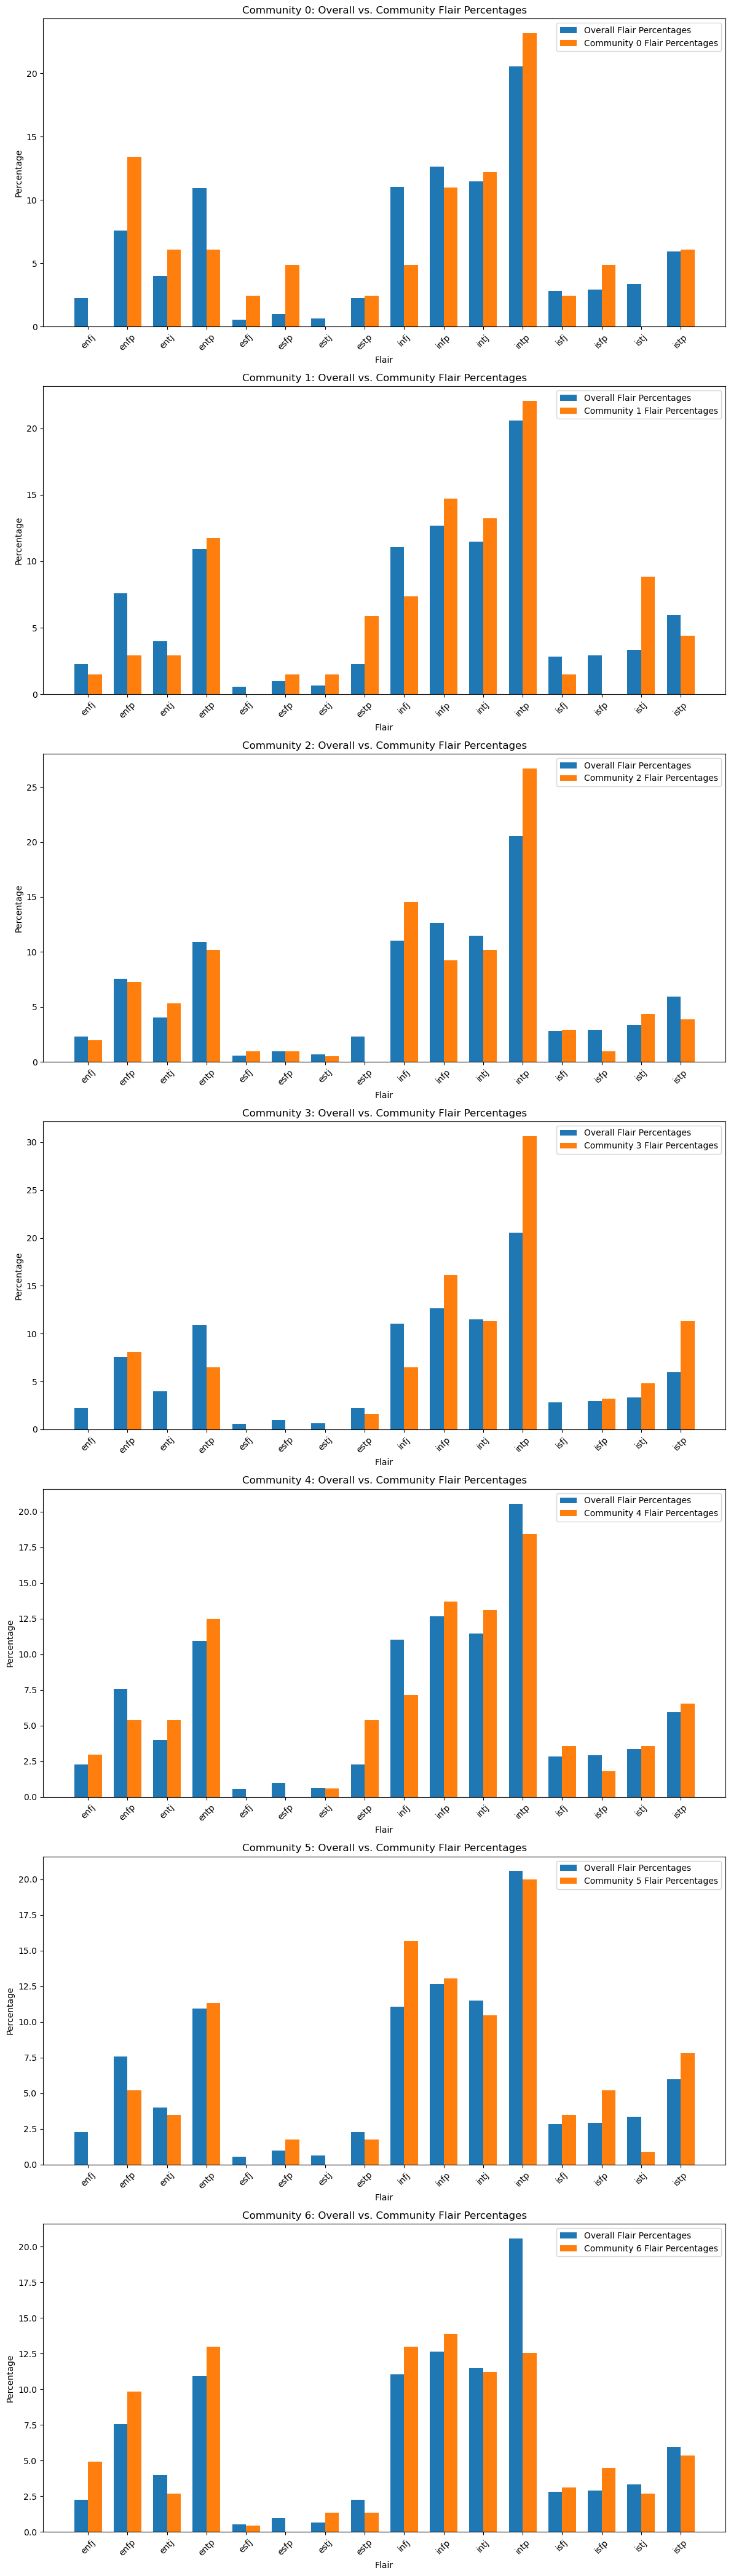

In [119]:
import matplotlib.pyplot as plt
import numpy as np

# Getting unique communities
unique_communities = merged_df['Community'].unique()

# Setting up subplots to display plots for each community
num_communities = len(unique_communities)
fig, axes = plt.subplots(num_communities, 1, figsize=(12, 6 * num_communities))

for idx, specific_community in enumerate(unique_communities):
    
    # Overall flair counts across all communities
    flair_counts = merged_df.groupby('Flair')['Author'].nunique()

    # Flair counts within a specific community
    community_data = merged_df[merged_df['Community'] == specific_community]
    community_flair_counts = community_data['Flair'].value_counts()

    # Calculate percentages
    total_flair_counts = flair_counts.sum()
    community_percentages = (community_flair_counts / community_flair_counts.sum()) * 100

    # Bar plot for overall flair counts and community flair counts side by side
    bar_width = 0.35
    index = np.arange(len(flair_counts))

    ax = axes[idx]
    rects1 = ax.bar(index, (flair_counts / total_flair_counts) * 100, bar_width, label='Overall Flair Percentages')
    rects2 = ax.bar(index + bar_width, community_percentages.reindex(flair_counts.index, fill_value=0).values,
                    bar_width, label=f'Community {specific_community} Flair Percentages')

    ax.set_xlabel('Flair')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Community {specific_community}: Overall vs. Community Flair Percentages')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(flair_counts.index, rotation=45)
    ax.legend()

plt.tight_layout()
plt.show()

Plot distribution of community sizes

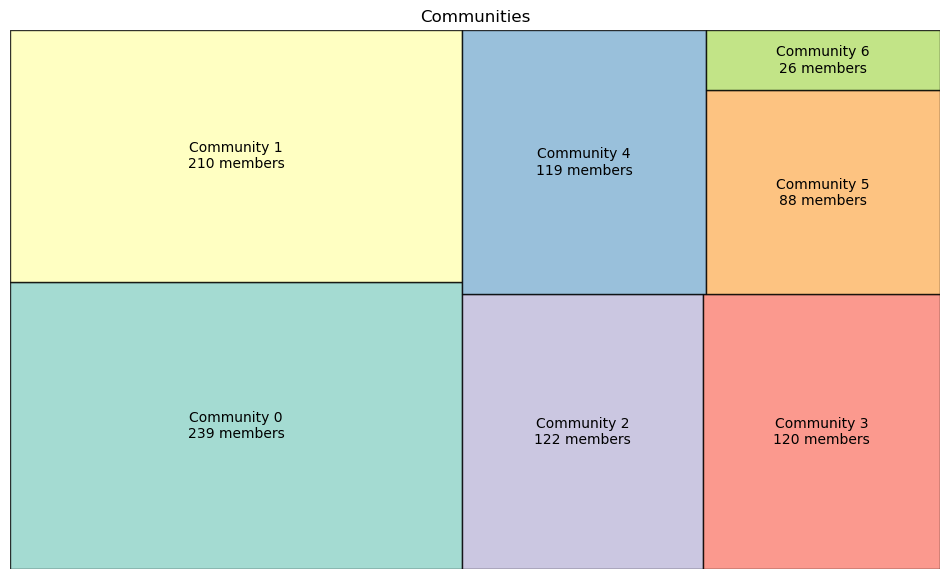

In [99]:
number_of_unique_communities = len(df_community['Community'].unique())
number_of_members_in_each_community = df_community['Community'].value_counts().values

labels = ['Community ' + str(i) + '\n' + str(number_of_members_in_each_community[i]) + ' members' for i in range(number_of_unique_communities)]
plt.figure(figsize=(12,7))
squarify.plot(sizes=df_community['Community'].value_counts().values,label=labels,alpha=.8,color=sb.color_palette("Set3", number_of_unique_communities),ec='black')
plt.title('Communities')
plt.axis('off')
plt.show()

Compute Modularity when divided into flairs 

In [46]:
# find the authors from the graph in data
authors = list(G.nodes())
flairs = nx.get_node_attributes(G,'flair')

# Make dataframe with authors and flairs
df_flairs = pd.DataFrame(list(flairs.items()),columns = ['Author','Flair'])

# Compute modularity for the authors divided into flairs
modularity_flairs = modularity(G, [df_flairs[df_flairs['Flair']==i]['Author'].values for i in df_flairs['Flair'].unique()])
print('Modularity Flairs:',modularity_flairs)

Modularity Flairs: 0.05613803884108744


Compute modularity of 4 larger groups: Analysts(intj,intp,entj,entp), Diplomats(infj,infp,enfj,enfp), Sentinels(istj,isfj,estj,esfj) and Explorers(istp,isfp,estp,esfp)

In [47]:
# Expand df_flairs with  a column contain superflairs
df_flairs['Superflair'] = df_flairs['Flair']
df_flairs['Superflair'] = df_flairs['Superflair'].replace(['intj','analyst'],['analyst','analyst'])
df_flairs['Superflair'] = df_flairs['Superflair'].replace(['intp','analyst'],['analyst','analyst'])
df_flairs['Superflair'] = df_flairs['Superflair'].replace(['entj','analyst'],['analyst','analyst'])
df_flairs['Superflair'] = df_flairs['Superflair'].replace(['entp','analyst'],['analyst','analyst'])
df_flairs['Superflair'] = df_flairs['Superflair'].replace(['infj','diplomat'],['diplomat','diplomat'])
df_flairs['Superflair'] = df_flairs['Superflair'].replace(['infp','diplomat'],['diplomat','diplomat'])
df_flairs['Superflair'] = df_flairs['Superflair'].replace(['enfj','diplomat'],['diplomat','diplomat'])
df_flairs['Superflair'] = df_flairs['Superflair'].replace(['enfp','diplomat'],['diplomat','diplomat'])
df_flairs['Superflair'] = df_flairs['Superflair'].replace(['istj','sentinel'],['sentinel','sentinel'])
df_flairs['Superflair'] = df_flairs['Superflair'].replace(['isfj','sentinel'],['sentinel','sentinel'])
df_flairs['Superflair'] = df_flairs['Superflair'].replace(['estj','sentinel'],['sentinel','sentinel'])
df_flairs['Superflair'] = df_flairs['Superflair'].replace(['esfj','sentinel'],['sentinel','sentinel'])
df_flairs['Superflair'] = df_flairs['Superflair'].replace(['istp','explorer'],['explorer','explorer'])
df_flairs['Superflair'] = df_flairs['Superflair'].replace(['isfp','explorer'],['explorer','explorer'])
df_flairs['Superflair'] = df_flairs['Superflair'].replace(['estp','explorer'],['explorer','explorer'])
df_flairs['Superflair'] = df_flairs['Superflair'].replace(['esfp','explorer'],['explorer','explorer'])

In [48]:
# Compute modularity for the authors divided into flairs
modularity_flairs = modularity(G, [df_flairs[df_flairs['Superflair']==i]['Author'].values for i in df_flairs['Superflair'].unique()])
print('Modularity Superflairs:',modularity_flairs)

Modularity Superflairs: 0.046415458983425154


# Text Analysis

Define lexical diversity

In [54]:
def lexical_diversity(text):
    return len(set(text)) / len(text)

Lexical Diversity of the different flairs

Lexical Diversity of intj: 0.08047387257969549
Lexical Diversity of entj: 0.10888028947632927
Lexical Diversity of estj: 0.30033305578684427
Lexical Diversity of istj: 0.16207370784952038
Lexical Diversity of esfj: 0.4172818063395571
Lexical Diversity of isfj: 0.17501747844325333
Lexical Diversity of infj: 0.0900727444079577
Lexical Diversity of enfj: 0.11490023069256557
Lexical Diversity of enfp: 0.11266928703575685
Lexical Diversity of infp: 0.11131588454268915
Lexical Diversity of isfp: 0.12797245248262581
Lexical Diversity of esfp: 0.2024982406755806
Lexical Diversity of istp: 0.1840798259434316
Lexical Diversity of estp: 0.13681440052639
Lexical Diversity of entp: 0.08816974663383234
Lexical Diversity of intp: 0.0686991891089573


<BarContainer object of 16 artists>

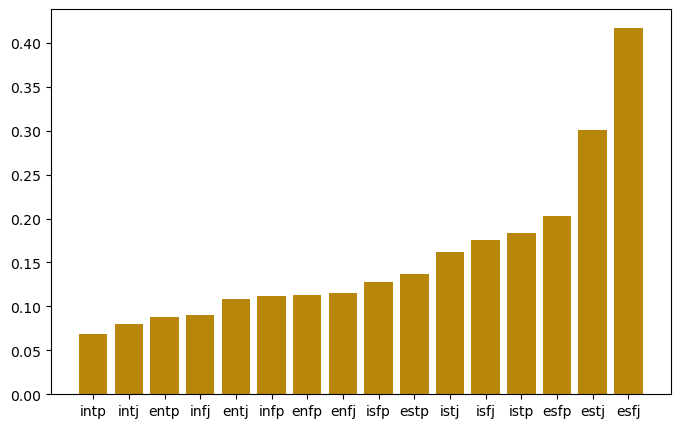

In [55]:
# lexical diversity of each flair
lexical_diversity_list = [0]*len(tmp)
for i in range(len(tmp)):
    lexical_diversity_list[i] = lexical_diversity(tmp[i])
    print('Lexical Diversity of',flair_list[i] + ':',lexical_diversity_list[i])

# sort lexical diversity and flair list
lexical_diversity_list, flair_list = zip(*sorted(zip(lexical_diversity_list, flair_list)))

# bar plot over lexical diversity of each flair sorted from highest to lowest
plt.figure(figsize=(8,5))
plt.bar(flair_list, lexical_diversity_list, color='darkgoldenrod')

Wow! Prospecting have always higher lexical diversity than Judging.

Wow! Thinking nearly always has a higher lexical diversity than Feeling.